In [11]:
from pyspark.sql import SparkSession 
from pyspark.sql.functions import col, sum
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
spark= SparkSession.builder.appName("fraud").config('spark.master','local[2]').getOrCreate()
df=spark.read.csv("AIML Dataset.csv",header=True,inferSchema=True)
df.show(5)


+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|   181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|   181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|      

In [3]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [4]:
df.describe().show()

+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+--------------------+
|summary|              step|    type|           amount|   nameOrig|    oldbalanceOrg|    newbalanceOrig|   nameDest|    oldbalanceDest|    newbalanceDest|             isFraud|      isFlaggedFraud|
+-------+------------------+--------+-----------------+-----------+-----------------+------------------+-----------+------------------+------------------+--------------------+--------------------+
|  count|           6362620| 6362620|          6362620|    6362620|          6362620|           6362620|    6362620|           6362620|           6362620|             6362620|             6362620|
|   mean|243.39724563151657|    NULL|179861.9035491287|       NULL|833883.1040744764| 855113.6685785812|       NULL|1100701.6665196533|1224996.3982019224|0.001290820448180152| 2.51468734577894E-6|
| stddev|142.33

In [5]:
dup =df.groupBy('step','type','amount','NameOrig').count().filter('count > 1').show()


+----+----+------+--------+-----+
|step|type|amount|NameOrig|count|
+----+----+------+--------+-----+
+----+----+------+--------+-----+



In [6]:
df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [6]:
df.count()

6362620

In [7]:
type_count = df.groupBy('type').count().show()

+--------+-------+
|    type|  count|
+--------+-------+
|TRANSFER| 532909|
| CASH_IN|1399284|
|CASH_OUT|2237500|
| PAYMENT|2151495|
|   DEBIT|  41432|
+--------+-------+



In [8]:
fraud_count = df.groupBy('isFraud').count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+



In [19]:
corr_df=df.corr('amount','oldbalanceOrg')
print(corr_df)

-0.0027624747580924057


In [9]:
df_pandas = df.select('amount').toPandas()
df_pandas.head()

,amount
0,9839.64
1,1864.28
2,181.00
3,181.00
4,11668.14


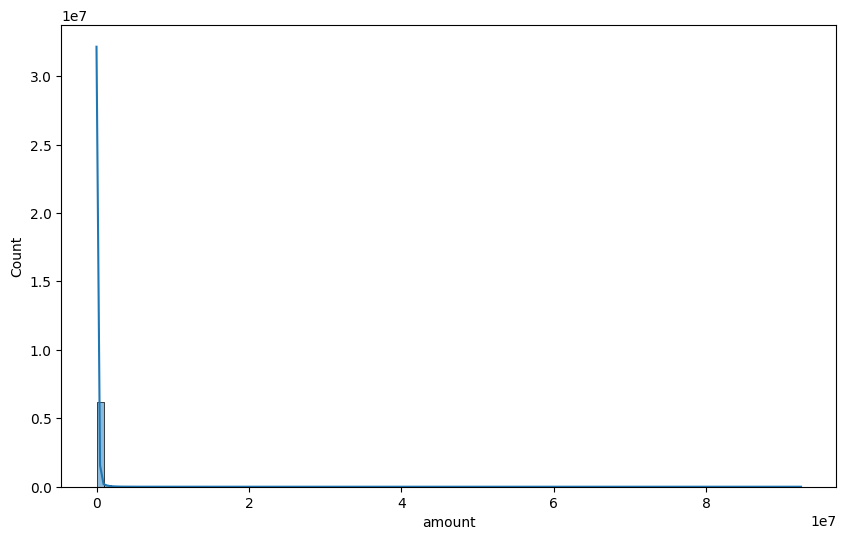

In [21]:
plt.figure(figsize=(10, 6)) 
sns.histplot(x=df_pandas['amount'],bins=100, kde=True)

plt.show()

In [21]:
spark.stop()

ConnectionRefusedError: [WinError 10061] No se puede establecer una conexión ya que el equipo de destino denegó expresamente dicha conexión